In [1]:
import scanpy as sc
import omicverse as ov
import scvelo as scv

ov.ov_plot_set()



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.4, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [80]:
ad = sc.read("data/depleted-bm-rna.h5ad")
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

In [81]:
new_order=['HSC','MEP','Mega','EryPre1','EryPre2','MylEry','Ery','HMP',
           'MyeloidPre','MonoPre','Mono','cDC',
           'CLP','pDC','proB','preproB','preB','NaiveB'
        ]
ad.obs['celltype']=ad.obs['celltype'].cat.reorder_categories(new_order)


Text(0.5, 1.0, 'Human hematopoiesis\nscRNA-seq')

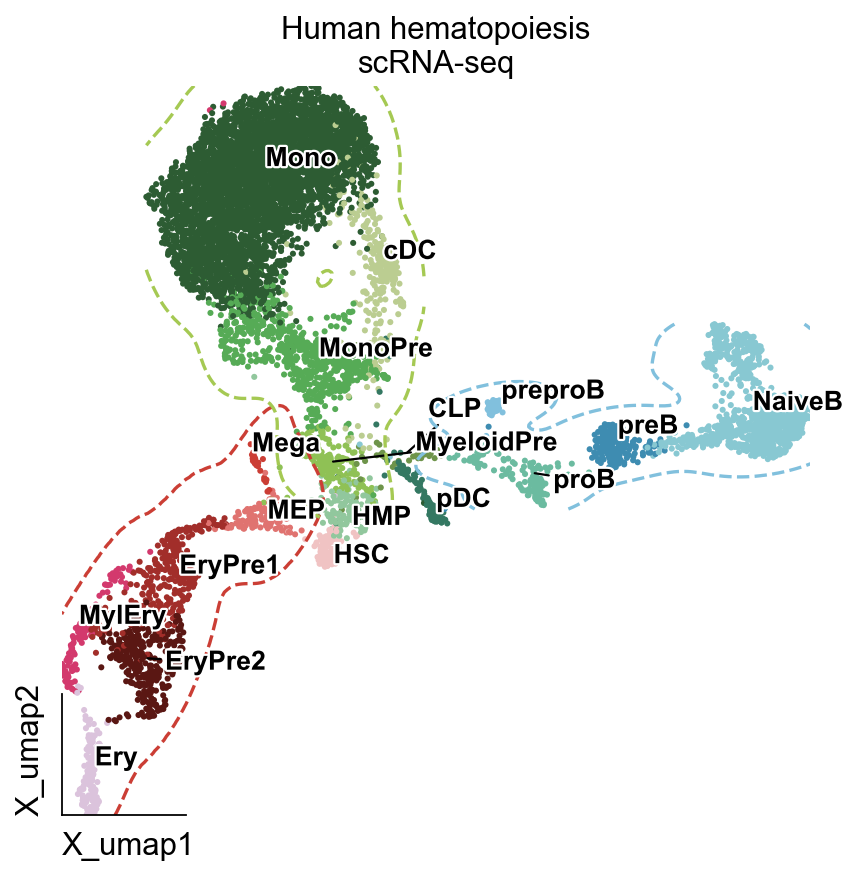

In [82]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(6,6))
ov.pl.embedding(
    ad,
    basis="X_umap",
    color=['celltype'],title='',
    show=False,  
    frameon='small',
    size=30,
    palette=ov.pl.red_color[:7]+ov.pl.green_color[:6]+ov.pl.blue_color[:],
    ax=ax,
    legend_loc=None, add_outline=False, 
)

ov.pl.embedding_adjust(
    ad,
    basis="X_umap",
    groupby='celltype',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='celltype',clusters=['MEP','Mega','EryPre1','EryPre2','MylEry','Ery'],
        contour_threshold=0.02,colors=ov.pl.red_color[2],linestyles='dashed')

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='celltype',clusters=[
           'MyeloidPre','MonoPre','Mono','cDC',],
        contour_threshold=0.01,colors=ov.pl.green_color[6],linestyles='dashed')

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='celltype',clusters=['proB','preproB','preB','NaiveB'],
        contour_threshold=0.02,colors=ov.pl.blue_color[2],linestyles='dashed')

plt.title('Human hematopoiesis\nscRNA-seq', fontsize=14)
#plt.savefig(f'figures/hsc/umap-ct-66.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/umap-ct-66.pdf',dpi=300,bbox_inches='tight')



In [83]:
meta_obj=ov.single.MetaCell(ad,use_rep='X_pca',
                            n_metacells=800,
                           use_gpu='cuda:0')
meta_obj.initialize_archetypes()
meta_obj.train(min_iter=10, max_iter=50)
meta_obj.save('result/hsc_rna_model.pkl')

Welcome to SEACells GPU!
Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/8627 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/8627 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/8627 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
Done.
Sampling waypoints ...
Done.
Selecting 667 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 143/143 [00:01<00:00, 93.37it/s]


Selecting 133 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.15331
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Converged after 12 iterations.


In [84]:
ad_meta=meta_obj.predicted(method='soft',celltype_label='celltype',
                     summarize_layer='MAGIC_imputed_data')
#ov.single.get_obs_value(ad_meta,ad,groupby='pt_via',
#                       type='mean')
ad_meta

100%|██████████| 794/794 [23:46<00:00,  1.80s/it]


AnnData object with n_obs × n_vars = 794 × 17226
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [85]:
import scanpy as sc
ad_meta.raw=ad_meta.copy()
sc.pp.highly_variable_genes(ad_meta, n_top_genes=2000, inplace=True)
ad_meta=ad_meta[:,ad_meta.var.highly_variable]
ov.pp.scale(ad_meta)
ov.pp.pca(ad_meta,layer='scaled',n_pcs=30)
ov.pp.neighbors(ad_meta, n_neighbors=15, n_pcs=20,
               use_rep='scaled|original|X_pca')
ov.pp.umap(ad_meta)
ad_meta.obs['celltype']=ad_meta.obs['celltype'].astype('category')
ad_meta.obs['celltype']=ad_meta.obs['celltype'].cat.reorder_categories(ad.obs['celltype'].cat.categories)
ad_meta.uns['celltype_colors']=ad.uns['celltype_colors']

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [86]:
ad_meta.obs['celltype']=ad_meta.obs['celltype'].astype('category')
ad_meta.obs['celltype']=ad_meta.obs['celltype'].cat.reorder_categories(ad.obs['celltype'].cat.categories)
ad_meta.uns['celltype_colors']=ad.uns['celltype_colors']

In [87]:
ov.pp.mde(ad_meta,embedding_dim=2,n_neighbors=15, basis='X_mde',
          n_pcs=30, use_rep='scaled|original|X_pca',)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsm['X_mde']`, MDE coordinates
    `.obsp['neighbors_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_connectivities']`, weighted adjacency matrix (0:00:01)


In [26]:
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped', 'SEACell'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'dista

In [88]:
ov.single.get_obs_value(ad_meta,ad,groupby='mellon_log_density',
                       type='mean')

... mellon_log_density have been added to ad.obs[mellon_log_density]


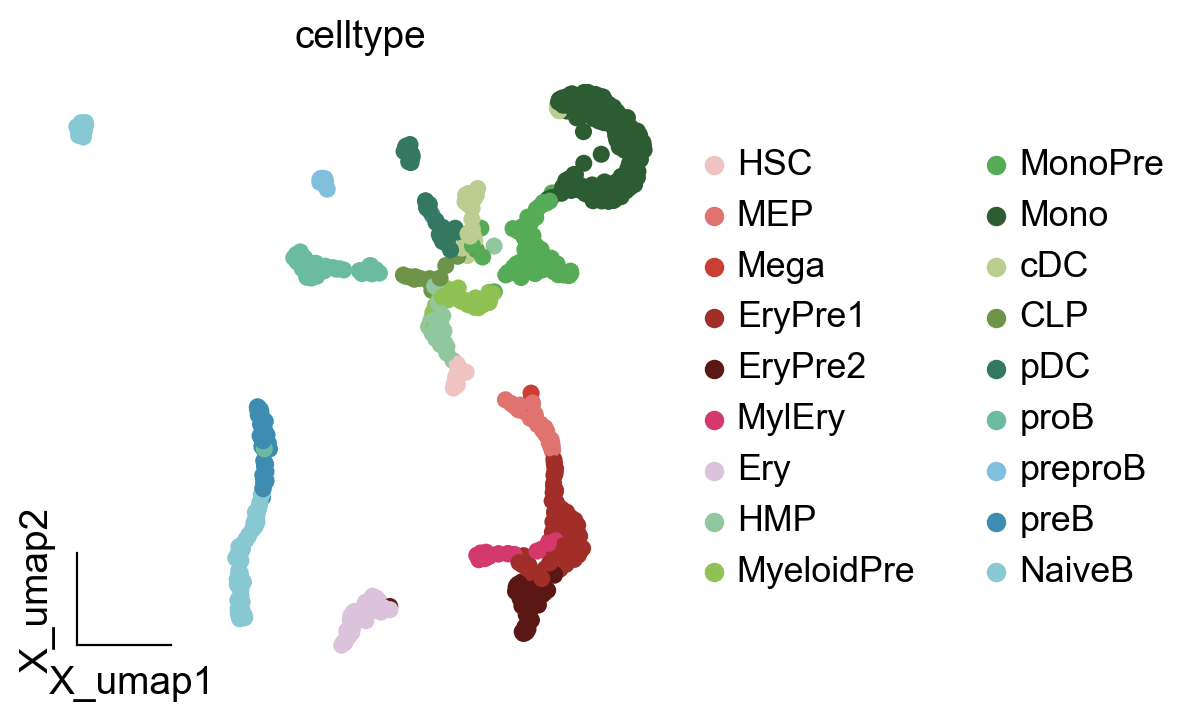

In [91]:
ov.pl.embedding(ad_meta,
                  basis='X_umap',
                  color='celltype',
                  frameon='small')

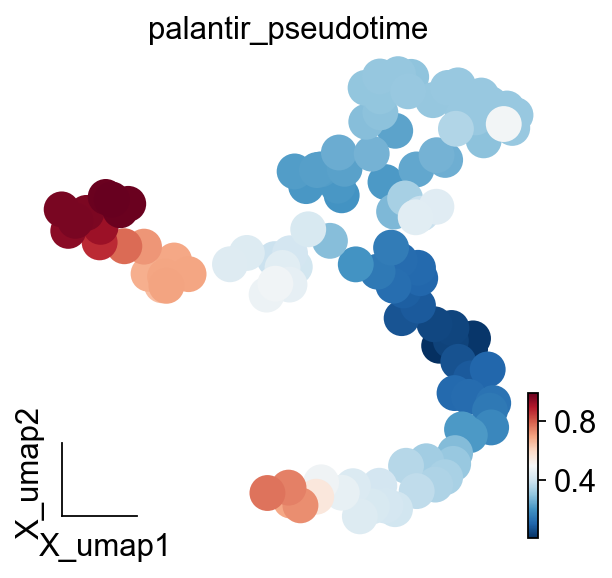

In [23]:
ov.pl.embedding(ad_meta,
                  basis='X_umap',
                  color='palantir_pseudotime',
                  frameon='small')

In [24]:
cfg_obj2=ov.single.Fate(ad_meta,pseudotime='palantir_pseudotime')
cfg_obj2.model_init()
cfg_obj2.ATR(stop=500)

$MSE|RMSE|MAE|R^2$:0.00072|0.027|0.019|0.99
coef_threshold:0.007441516091969948, r2:0.9810606220357468


,coef_threshold,r2
0,0.015790,0.470942
1,0.010928,0.466609
2,0.010777,0.662600
3,0.010577,0.666720
4,0.010146,0.845546
...,...,...
495,0.001881,0.990945
496,0.001880,0.990902
497,0.001880,0.990902
498,0.001878,0.990986


Text(0.5, 1.0, 'HSC\nOmicFate')

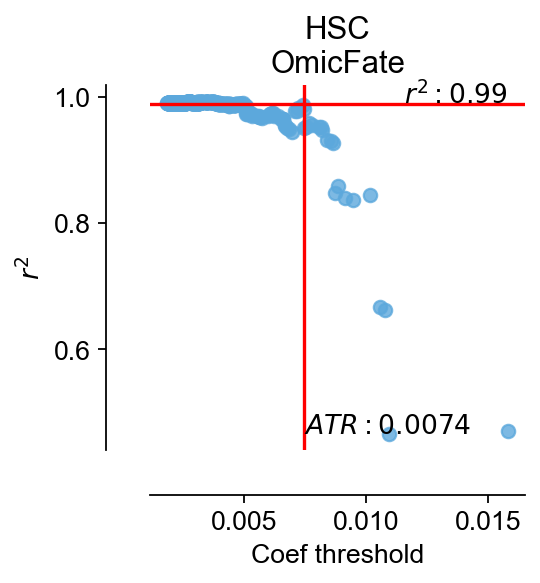

In [25]:
fig,ax=cfg_obj2.plot_filtering(color='#5ca8dc')
ax.set_title('HSC\nOmicFate')

In [26]:
res=cfg_obj2.model_fit()

$MSE|RMSE|MAE|R^2$:0.0012|0.035|0.029|0.98


(<Figure size 240x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Regression RNA\nDimension: 2000'}, xlabel='True pseudotime', ylabel='Predicted pseudotime'>)

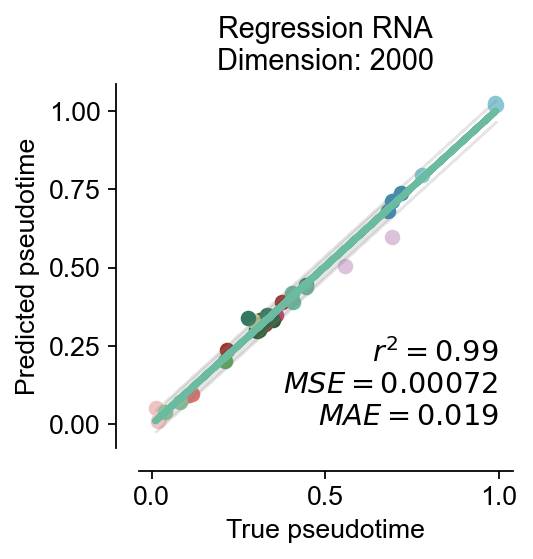

In [27]:
cfg_obj2.plot_color_fitting(type='raw',cluster_key='celltype')

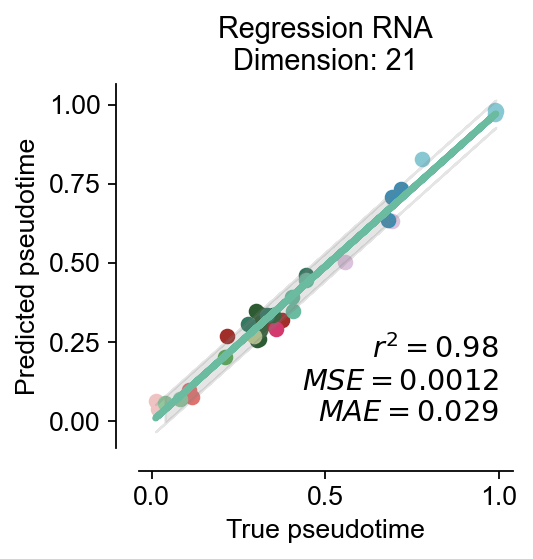

In [29]:
fig,ax=cfg_obj2.plot_color_fitting(type='filter',cluster_key='celltype')
#ax.text(1.1,0.5,'rmse')

In [30]:
ov.pp.leiden(ad_meta,resolution=2)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


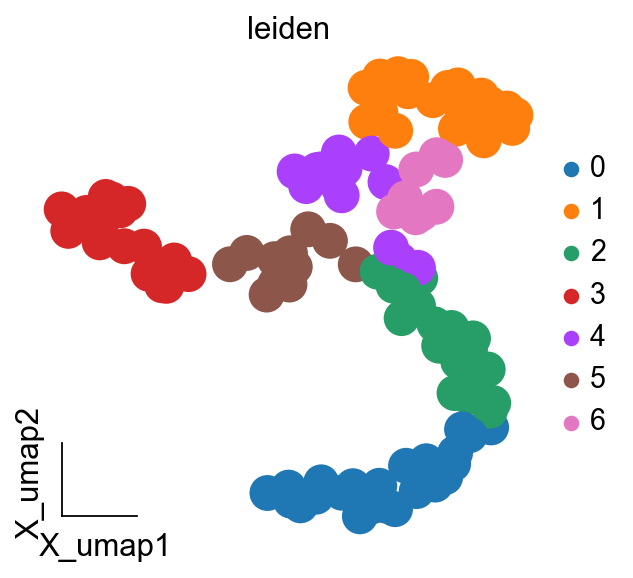

In [31]:
ov.pl.embedding(ad_meta,
                  basis='X_umap',
                  color='leiden',
                  frameon='small')

In [32]:
cfg_obj2.low_density(pca_key='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
[2024-07-05 01:07:31,120] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (115) >= n_samples (115) and rank = 1.0.
[2024-07-05 01:07:31,121] [INFO    ] Computing nearest neighbor distances.
[2024-07-05 01:07:31,985] [INFO    ] Using d=1.5030975880603137.
[2024-07-05 01:07:32,118] [INFO    ] Using covariance function Matern52(ls=0.7939004838848901).
[2024-07-05 01:07:32,511] [INFO    ] Using rank 115 covariance representation.
[2024-07-05 01:07:32,666] [INFO    ] Running inference using L-BFGS-B.


In [33]:
ad_meta

AnnData object with n_obs × n_vars = 115 × 2000
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity', 'palantir_pseudotime', 'leiden', 'mellon_log_density_lowd'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'umap', 'celltype_colors', 'leiden', 'leiden_colors', 'DM_EigenValues'
    obsm: 'scaled|original|X_pca', 'X_umap', 'X_mde', 'DM_EigenVectors'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities', 'DM_Kernel', 'DM_Similarity'

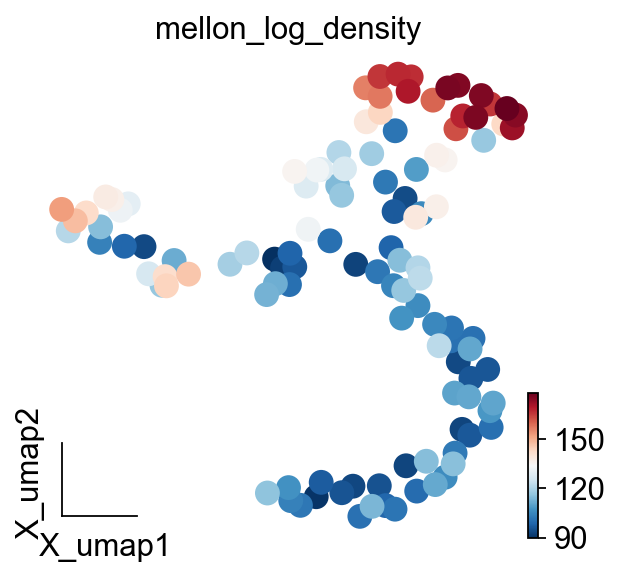

In [28]:
ov.pl.embedding(ad_meta,
                  basis='X_umap',
                  color='mellon_log_density',
                  frameon='small',size=500)

In [ ]:
cfg_obj2.lineage_score(cluster_key='leiden',lineage=['5'],
                      expression_key=None)
#palantir,mellon

In [39]:
scores = ad_meta.var["change_scores_lineage"]
scores.sort_values(ascending=False)

ACSM3         2.384227e-03
ERG           2.094464e-03
ROR1          1.934969e-03
AL589693.1    1.483974e-03
DNTT          1.441263e-03
                  ...     
AL359915.1    2.666191e-08
LINC00570     1.816024e-08
AL136018.1    5.074975e-09
GPR39         3.047307e-09
PCAT18        2.706729e-09
Name: change_scores_lineage, Length: 2000, dtype: float64

In [40]:
od_genes=scores.loc[cfg_obj2.filter_coef.index].sort_values(ascending=False)[:20]
od_genes

BANK1         0.000452
RTN1          0.000407
SETBP1        0.000309
FOXO3         0.000289
JAZF1         0.000265
DOCK4         0.000197
CAMKMT        0.000121
CPED1         0.000070
SPTA1         0.000055
CA1           0.000052
PAPSS2        0.000050
AGAP1         0.000043
SLC25A21      0.000038
RNF19A        0.000034
MXI1          0.000027
NCEH1         0.000015
SLC25A39      0.000015
ADGRB3        0.000014
AC069410.1    0.000013
PHLPP2        0.000011
Name: change_scores_lineage, dtype: float64

[Text(1, 0.5, 'FOXO3'),
 Text(1, 1.5, 'CPED1'),
 Text(1, 2.5, 'BANK1'),
 Text(1, 3.5, 'RTN1'),
 Text(1, 4.5, 'DOCK4'),
 Text(1, 5.5, 'SPTA1'),
 Text(1, 6.5, 'CA1'),
 Text(1, 7.5, 'SETBP1'),
 Text(1, 8.5, 'JAZF1'),
 Text(1, 9.5, 'CAMKMT')]

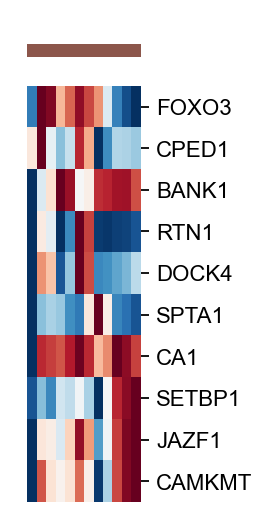

In [44]:
import matplotlib.pyplot as plt
visual_cluster=['5']
g=ov.utils.plot_heatmap(ad_meta[ad_meta.obs['leiden'].isin(visual_cluster)],
                        var_names=scores.loc[cfg_obj2.filter_coef.index].sort_values(ascending=False)[:10].index.tolist(),
                  sortby='palantir_pseudotime',col_color='leiden',yticklabels=True,
                 n_convolve=2,figsize=(1,6),show=False)

g.fig.set_size_inches(1, 4)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=10)

In [4]:
import omicverse as ov
pathway_dict=ov.utils.geneset_prepare('../placenta/genesets/GO_Biological_Process_2021.txt',organism='Human')
len(pathway_dict.keys())

6036

In [5]:
ov.plot_set()

All dependencies are satisfied.


In [53]:
ad.write('data/geneset/ad.h5ad')

In [2]:
ad=sc.read('data/geneset/ad.h5ad')

In [54]:
ad_meta.write('data/geneset/ad_meta.h5ad')

In [3]:
ad_meta=sc.read('data/geneset/ad_meta.h5ad')

In [7]:
ad_meta_raw=ad_meta.raw.to_adata()

## metacell

In [ ]:
##Assest all pathways
adata_aucs=ov.single.pathway_aucell_enrichment(ad_meta_raw,
                                                pathways_dict=pathway_dict,
                                                num_workers=8)

In [9]:
adata_aucs.obs=ad_meta_raw[adata_aucs.obs.index].obs
adata_aucs.obsm=ad_meta_raw[adata_aucs.obs.index].obsm
adata_aucs.obsp=ad_meta_raw[adata_aucs.obs.index].obsp
adata_aucs.uns=ad_meta_raw[adata_aucs.obs.index].uns

adata_aucs

AnnData object with n_obs × n_vars = 115 × 6036
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity', 'palantir_pseudotime', 'leiden', 'mellon_log_density_lowd'
    uns: 'DM_EigenValues', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'DM_EigenVectors', 'X_mde', 'X_umap', 'scaled|original|X_pca', 'specification'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances'

In [10]:
cfg_obj=ov.single.Fate(adata_aucs,pseudotime='palantir_pseudotime')
cfg_obj.model_init()
cfg_obj.ATR(stop=500)

$MSE|RMSE|MAE|R^2$:0.00044|0.021|0.016|0.99
coef_threshold:0.025227982961247977, r2:0.9847292322609168


,coef_threshold,r2
0,0.047204,0.779536
1,0.047204,0.779536
2,0.042453,0.795245
3,0.041194,0.744515
4,0.038175,0.834718
...,...,...
495,0.009582,0.989225
496,0.009558,0.989038
497,0.009555,0.989025
498,0.009512,0.988985


Text(0.5, 1.0, 'HSC\nOmicFate')

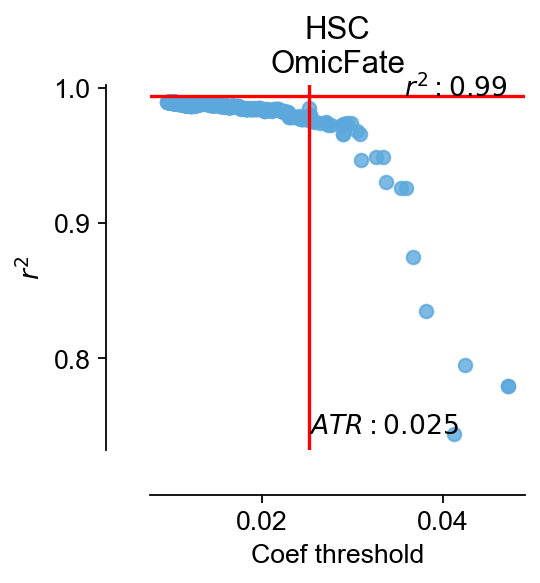

In [11]:
fig,ax=cfg_obj.plot_filtering(color='#5ca8dc')
ax.set_title('HSC\nOmicFate')

In [12]:
res=cfg_obj.model_fit()

$MSE|RMSE|MAE|R^2$:0.001|0.032|0.025|0.99


(<Figure size 240x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Regression RNA\nDimension: 6036'}, xlabel='True pseudotime', ylabel='Predicted pseudotime'>)

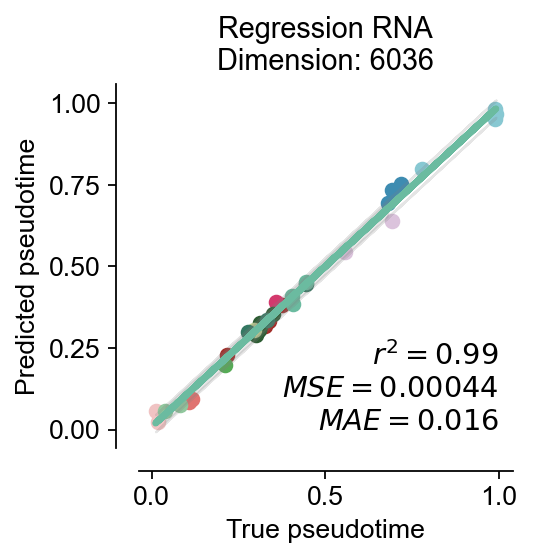

In [13]:
cfg_obj.plot_color_fitting(type='raw',cluster_key='celltype')

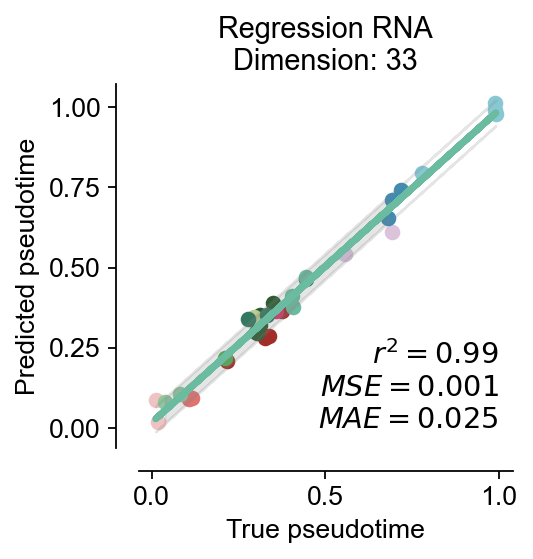

In [14]:
fig,ax=cfg_obj.plot_color_fitting(type='filter',cluster_key='celltype')
#ax.text(1.1,0.5,'rmse')

In [15]:
cfg_obj.low_density(pca_key='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
[2024-07-05 02:01:37,804] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (115) >= n_samples (115) and rank = 1.0.
[2024-07-05 02:01:37,804] [INFO    ] Computing nearest neighbor distances.
[2024-07-05 02:01:38,899] [INFO    ] Using d=1.5030975880603137.
[2024-07-05 02:01:39,033] [INFO    ] Using covariance function Matern52(ls=0.7939004838848901).
[2024-07-05 02:01:39,433] [INFO    ] Using rank 115 covariance representation.
[2024-07-05 02:01:39,582] [INFO    ] Running inference using L-BFGS-B.


In [30]:
ov.single.get_obs_value(adata_aucs,ad,groupby='mellon_log_density',
                       type='mean')

... mellon_log_density have been added to ad.obs[mellon_log_density]


In [36]:
del adata_aucs.layers['local_variability']

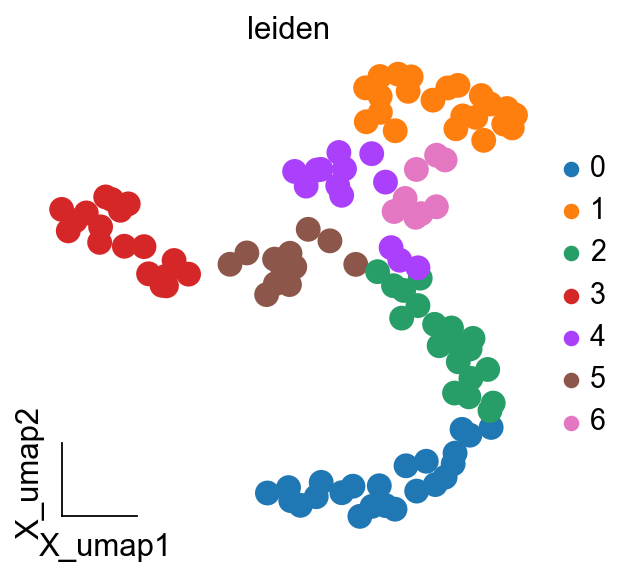

In [17]:
ov.pl.embedding(adata_aucs,
                  basis='X_umap',
                  color='leiden',
                  frameon='small',size=500)

In [37]:
cfg_obj.lineage_score(cluster_key='leiden',lineage=['5'],
                      expression_key=None)
#palantir,mellon

Run low_density first


100%|██████████| 115/115 [00:00<00:00, 301.58it/s]

Calculating lineage score
The lineage score stored in adata.var['change_scores_lineage']


In [38]:
scores = adata_aucs.var["change_scores_lineage"]
scores.sort_values(ascending=False)

Regulon
negative regulation of interferon-alpha production (GO:0032687)                        0.001327
negative regulation of cytokinesis (GO:0032466)                                        0.001248
copper ion import (GO:0015677)                                                         0.001190
regulation of microtubule motor activity (GO:2000574)                                  0.000864
retinal ganglion cell axon guidance (GO:0031290)                                       0.000760
                                                                                         ...   
positive regulation of pathway-restricted SMAD protein phosphorylation (GO:0010862)    0.000000
homophilic cell adhesion via plasma membrane adhesion molecules (GO:0007156)           0.000000
homologous chromosome segregation (GO:0045143)                                         0.000000
positive regulation of peptide hormone secretion (GO:0090277)                          0.000000
phototransduction, visible light

In [39]:
od_genes=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:20]
od_genes

Regulon
regulation of microtubule motor activity (GO:2000574)                          0.000864
negative regulation of immunoglobulin production (GO:0002638)                  0.000685
positive regulation of T-helper 1 cell cytokine production (GO:2000556)        0.000513
regulation of T-helper 1 cell cytokine production (GO:2000554)                 0.000513
regulation of fever generation (GO:0031620)                                    0.000471
negative regulation of leukocyte differentiation (GO:1902106)                  0.000458
negative regulation of dendritic cell differentiation (GO:2001199)             0.000458
positive regulation of leukocyte tethering or rolling (GO:1903238)             0.000442
positive regulation of prostaglandin secretion (GO:0032308)                    0.000437
postsynaptic density organization (GO:0097106)                                 0.000427
positive regulation of heat generation (GO:0031652)                            0.000400
regulation of vascular a

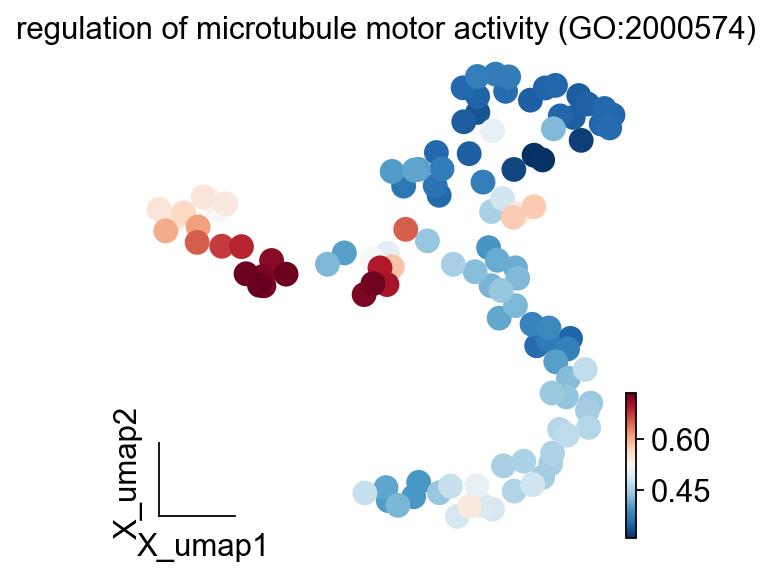

In [40]:
ov.pl.embedding(adata_aucs,
                  basis='X_umap',
                  color='regulation of microtubule motor activity (GO:2000574)',
                  frameon='small',size=500)

## all cells

In [ ]:
##Assest all pathways
adata_aucs_all=ov.single.pathway_aucell_enrichment(ad,
                                                pathways_dict=pathway_dict,
                                                num_workers=8)

In [42]:
adata_aucs_all.obs=ad[adata_aucs_all.obs.index].obs
adata_aucs_all.obsm=ad[adata_aucs_all.obs.index].obsm
adata_aucs_all.obsp=ad[adata_aucs_all.obs.index].obsp
adata_aucs_all.uns=ad[adata_aucs_all.obs.index].uns

adata_aucs_all

AnnData object with n_obs × n_vars = 8627 × 6036
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped', 'SEACell'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn'

In [245]:
adata_aucs_all.write('data/geneset/adata_aucs_all.h5ad',compression='gzip')

In [43]:
cfg_obj3=ov.single.Fate(adata_aucs_all,pseudotime='palantir_pseudotime')
cfg_obj3.model_init()
cfg_obj3.ATR(stop=500)

$MSE|RMSE|MAE|R^2$:0.0033|0.058|0.044|0.94


,coef_threshold,r2
0,0.525999,0.119153
1,0.468170,0.232434
2,0.424521,0.329571
3,0.397430,0.337888
4,0.394920,0.369871
...,...,...
495,0.084445,0.922314
496,0.084368,0.922320
497,0.084310,0.922319
498,0.084289,0.922385


In [45]:
cfg_obj3.coef_threshold=0.08

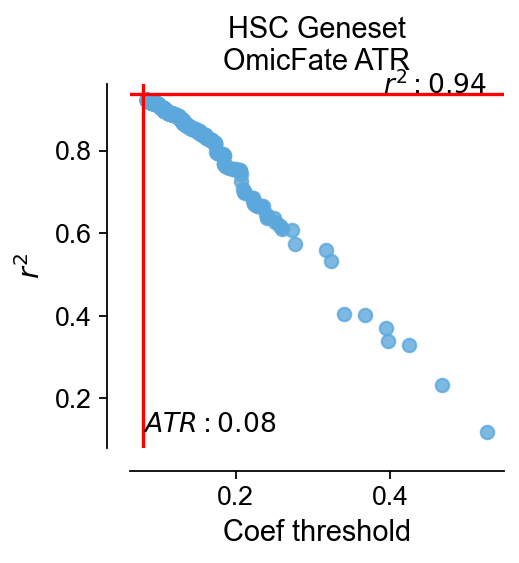

In [178]:
fig,ax=cfg_obj3.plot_filtering(color='#5ca8dc')
#ax.set_title()

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('Coef threshold', fontsize=13)
ax.set_ylabel('$r^2$', fontsize=13)
ax.set_title('HSC Geneset\nOmicFate ATR', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=12,rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.savefig(f'figures/geneset/atr-filter-33.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/atr-filter-33.pdf',dpi=300,bbox_inches='tight')


In [47]:
res=cfg_obj3.model_fit()

$MSE|RMSE|MAE|R^2$:0.0041|0.064|0.048|0.92


In [170]:
cfg_obj3.coef.shape[0]

6036

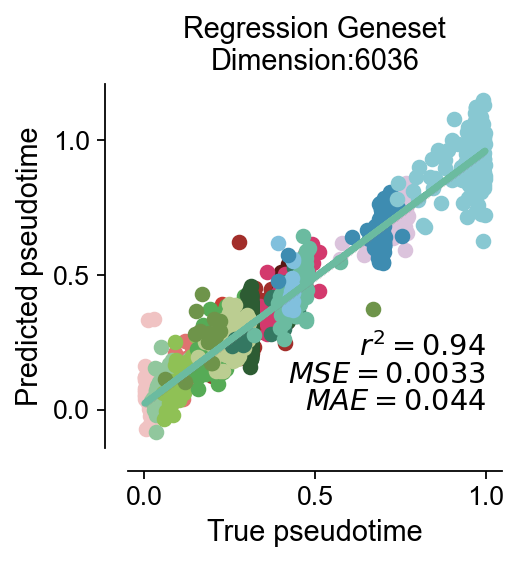

In [176]:
fig,ax=cfg_obj3.plot_color_fitting(type='raw',cluster_key='celltype',figsize=(3,3))

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('True pseudotime', fontsize=13)
ax.set_ylabel('Predicted pseudotime', fontsize=13)
ax.set_title(f'Regression Geneset\nDimension:{cfg_obj3.coef.shape[0]}', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=12,rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.savefig(f'figures/geneset/reg-raw-33.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/reg-raw-33.pdf',dpi=300,bbox_inches='tight')



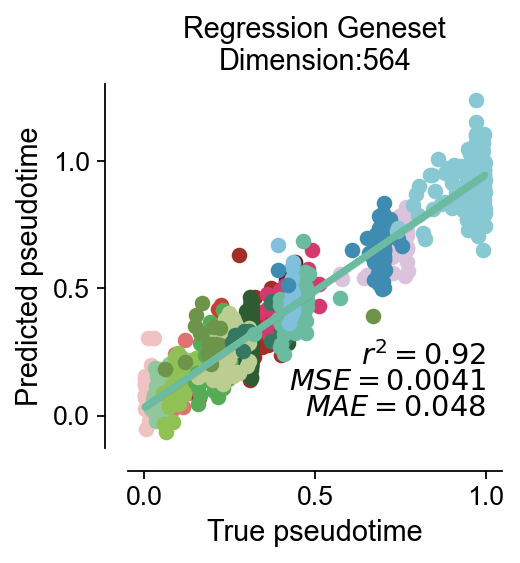

In [177]:
fig,ax=cfg_obj3.plot_color_fitting(type='filter',cluster_key='celltype')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('True pseudotime', fontsize=13)
ax.set_ylabel('Predicted pseudotime', fontsize=13)
ax.set_title(f'Regression Geneset\nDimension:{cfg_obj3.filter_coef.shape[0]}', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=12,rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.savefig(f'figures/geneset/reg-filter-33.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/reg-filter-33.pdf',dpi=300,bbox_inches='tight')



In [30]:
#ov.single.get_obs_value(adata_aucs_all,ad,groupby='mellon_log_density',
#                       type='mean')

... mellon_log_density have been added to ad.obs[mellon_log_density]


In [123]:
from scipy.sparse import issparse, csr_matrix
X=ad.X
if issparse(X):
    pass
else:
    X=csr_matrix(X)

In [ ]:
del adata_aucs_all.layers['local_variability']

In [63]:
adata_aucs_all=adata_aucs_all.copy()

In [68]:
ov.pp.leiden(adata_aucs_all,resolution=2)

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


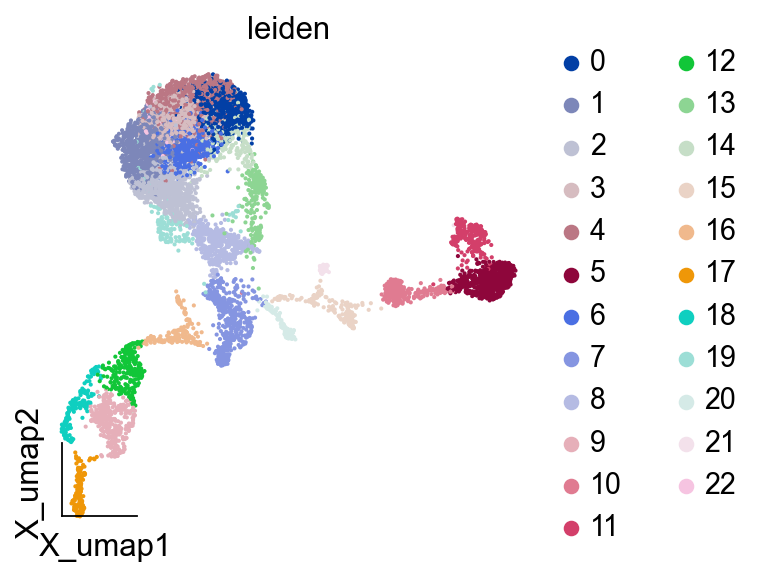

In [124]:
ov.pl.embedding(adata_aucs_all,
                  basis='X_umap',
                  color='leiden',
                  frameon='small')

In [109]:
from scipy.sparse import csr_matrix
adata_aucs_all.X=csr_matrix(adata_aucs_all.X)

In [113]:
ov.plot_set()

All dependencies are satisfied.


In [78]:
cfg_obj3.adata=adata_aucs_all

In [ ]:
cfg_obj3.low_density(pca_key='X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
[2024-07-05 03:42:16,513] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,627) and rank = 1.0.
[2024-07-05 03:42:16,515] [INFO    ] Computing nearest neighbor distances.
[2024-07-05 03:42:16,631] [INFO    ] Using d=1.7352303437057968.
[2024-07-05 03:42:16,634] [INFO    ] Using covariance function Matern52(ls=0.0010437683199839192).
[2024-07-05 03:42:16,635] [INFO    ] Computing 5,000 landmarks with k-means clustering.


In [145]:
adata_aucs_all

AnnData object with n_obs × n_vars = 8627 × 6036
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped', 'SEACell', 'leiden', 'mellon_log_density_lowd'
    var: 'change_scores_lineage'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap', 'leiden_colors'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells', 'specification'
    layers: 'local_variability'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn'

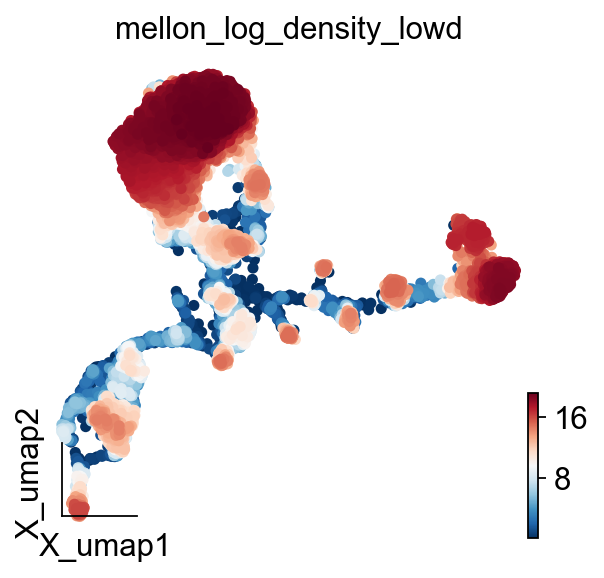

In [146]:
ov.pl.embedding(adata_aucs_all,
                  basis='X_umap',
                  color='mellon_log_density_lowd',
                  frameon='small',size=100)

### preB

In [229]:
cfg_obj3.lineage_score(cluster_key='leiden',lineage=['20','15'],
                      expression_key=None)
#palantir,mellon

Calculating lineage score
The lineage score stored in adata.var['change_scores_lineage']


In [230]:
scores = adata_aucs_all.var["change_scores_lineage"]
scores.sort_values(ascending=False)

Regulon
CRD-mediated mRNA stabilization (GO:0070934)                                            0.003390
peptidyl-cysteine S-nitrosylation (GO:0018119)                                          0.002931
positive regulation of maintenance of sister chromatid cohesion (GO:0034093)            0.002533
regulation of maintenance of mitotic sister chromatid cohesion (GO:0034182)             0.002533
positive regulation of maintenance of mitotic sister chromatid cohesion (GO:0034184)    0.002533
                                                                                          ...   
lipid homeostasis (GO:0055088)                                                          0.000000
lipid droplet organization (GO:0034389)                                                 0.000000
lipid catabolic process (GO:0016042)                                                    0.000000
positive regulation of smooth muscle cell differentiation (GO:0051152)                  0.000000
phototransduction, vis

In [231]:
od_genes=scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:20]
od_genes

Regulon
positive regulation of store-operated calcium channel activity (GO:1901341)    0.001725
regulation of neutrophil activation (GO:1902563)                               0.001143
tricuspid valve morphogenesis (GO:0003186)                                     0.001104
astral microtubule organization (GO:0030953)                                   0.001103
regulation of cyclase activity (GO:0031279)                                    0.001085
cotranslational protein targeting to membrane (GO:0006613)                     0.001067
axon choice point recognition (GO:0016198)                                     0.001033
marginal zone B cell differentiation (GO:0002315)                              0.000984
positive regulation of granulocyte differentiation (GO:0030854)                0.000956
establishment of centrosome localization (GO:0051660)                          0.000889
Schwann cell differentiation (GO:0014037)                                      0.000869
regulation of skeletal m

In [ ]:
# 创建横向柱状图
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(1, 3))

od_genes=scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:5]

norm = plt.Normalize(min(od_genes.values), max(od_genes.values))
colors = cm.Reds(norm(od_genes.values))

plt.barh(od_genes.index, od_genes.values, color=colors)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('')
ax.set_ylabel('$R^2$', fontsize=13)
ax.set_title('', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
ax.set_yticklabels([plot_text_set(i.get_text().split('(')[0],4) for i in ax.get_yticklabels()], fontsize=11)

plt.xlabel('Scores',fontsize=12)
plt.ylabel('Pathway',fontsize=12)
plt.title('Fate Rank',fontsize=12)
plt.gca().invert_yaxis()  # 反转y轴使得最高分数在顶部



100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:020:00


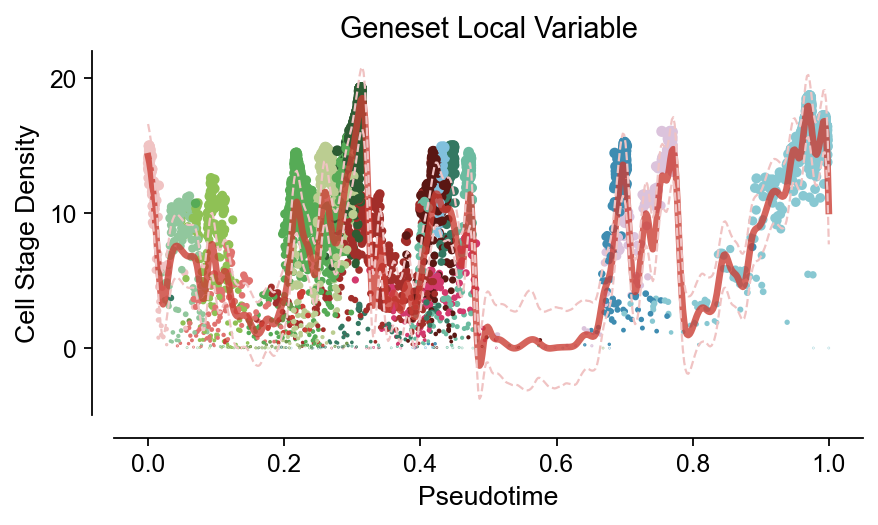

In [242]:
fig, ax = plt.subplots(figsize=(6,3))
#visual_cluster=['CLP','proB', 'preproB', 'preB', 'NaiveB']
#x=ad[ad.obs['leiden'].isin(visual_cluster),gene].to_df().values.reshape(-1)
#ad1=adata_aucs_all[adata_aucs_all.obs['celltype'].isin(visual_cluster)]
ad1=adata_aucs_all.copy()
x=ad1.obs['palantir_pseudotime'].values.reshape(-1)
y=ad1.obs['mellon_log_density_lowd'].values.reshape(-1)
#z=ad1[:,'marginal zone B cell differentiation (GO:0002315)'].to_df().values.reshape(-1)

color_dict=dict(zip(ad1.obs['celltype'].cat.categories,
                   ad1.uns['celltype_colors']))

from pygam import LinearGAM

gam = LinearGAM(n_splines=100).gridsearch(x.reshape(x.shape[0],1), y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), '-',linewidth=3,
        color=ov.pl.red_color[2],alpha=0.8)
plt.plot(XX, gam.prediction_intervals(XX, width=.65), 
         color=ov.pl.red_color[0], ls='--',linewidth=1,)

ax.scatter(x,y,c=[color_dict[i] for i in ad1.obs['celltype'].tolist()],
           cmap='RdBu_r',s=y)

#ax.scatter(x,y,c=z,
#           cmap='RdBu_r',s=10)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)


# 设置标签和标题
ax.set_xlabel('')
ax.set_ylabel('$R^2$', fontsize=13)
ax.set_title('', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)

plt.xlabel('Pseudotime',fontsize=12)
plt.ylabel('Cell Stage Density',fontsize=12)
plt.title('Geneset Local Variable',fontsize=13)

plt.savefig(f'figures/geneset/density_pt.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/density_pt.pdf',dpi=300,bbox_inches='tight')



In [163]:
def plot_text_set(text, text_knock=2, text_maxsize=20):
    """
    Formats the text to fit in a plot by adding line breaks.

    Parameters
    ----------
    - text : str
        Text to format.
    - text_knock : int, optional
        Number of words to skip between two line breaks, by default 2.
    - text_maxsize : int, optional
        Maximum length of the text before formatting, by default 20.

    Returns
    -------
    - text: str
        Formatted text.
    """
    if len(text) <= text_maxsize:
        return text
    
    words = text.split(' ')
    formatted_text = []
    for i, word in enumerate(words):
        if i > 0 and i % text_knock == 0:
            formatted_text.append('\n')
        formatted_text.append(word)
    
    return ' '.join(formatted_text).strip()


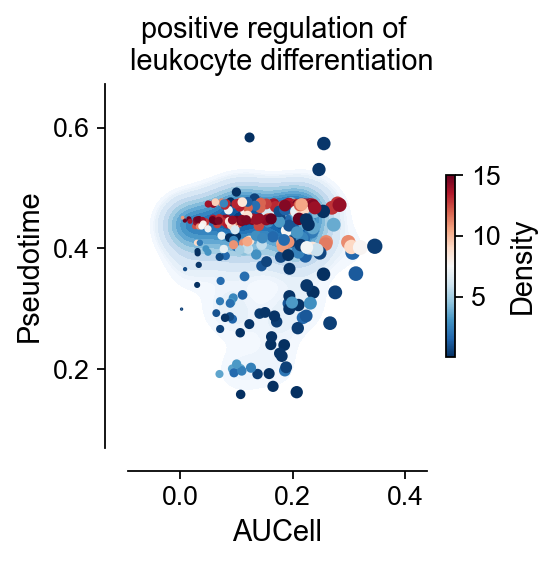

In [243]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(3,3))

path='positive regulation of leukocyte differentiation (GO:1902107)'
visual_cluster=['20','15']

x=adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster),path].to_df().values.reshape(-1)
y=adata_aucs_all.obs.loc[adata_aucs_all.obs['leiden'].isin(visual_cluster),'palantir_pseudotime'].values.reshape(-1)
z=adata_aucs_all.obs.loc[adata_aucs_all.obs['leiden'].isin(visual_cluster),'mellon_log_density_lowd'].values.reshape(-1)

sns.kdeplot(
        x=x, y=y,
        fill=True,
        cmap='Blues',
        #clip=(-5, 5), cut=10,
        thresh=0.1, levels=15,
        ax=ax,#cbar=True,
    )
scatter=ax.scatter(x,y,
           c=z, s=x*100,
           cmap='RdBu_r',
          )

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

plt.xlabel('AUCell',fontsize=13)
plt.ylabel('Pseudotime',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(plot_text_set(path.split('(')[0],text_knock=3, text_maxsize=20),fontsize=13)
cbar = plt.colorbar(scatter, ax=ax,shrink=0.5)
cbar.set_label('Density', fontsize=13)
cbar.ax.tick_params(labelsize=12)

plt.savefig(f'figures/geneset/density-lineage-B-{path.split("(")[1]}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/density-lineage-B-{path.split("(")[1]}.pdf',dpi=300,bbox_inches='tight')


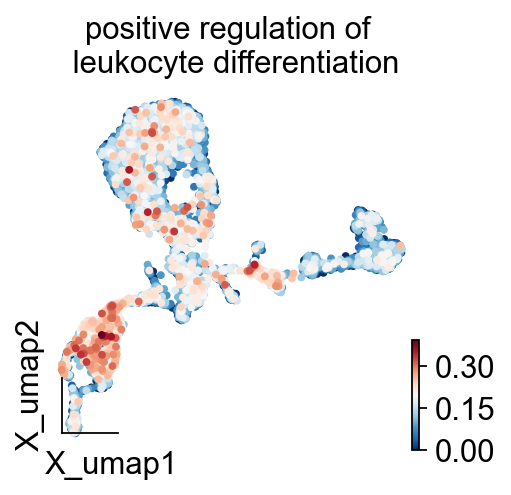

In [234]:
#path='cotranslational protein targeting to membrane (GO:0006613)'
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(adata_aucs_all,
                  basis='X_umap',
                  color=path,
                  title=plot_text_set(path.split('(')[0],3),
                ax=ax,show=False,
                  frameon='small',size=50)
plt.savefig(f'figures/geneset/umap-lineage-B-{path.split("(")[1]}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/umap-lineage-B-{path.split("(")[1]}.pdf',dpi=300,bbox_inches='tight')


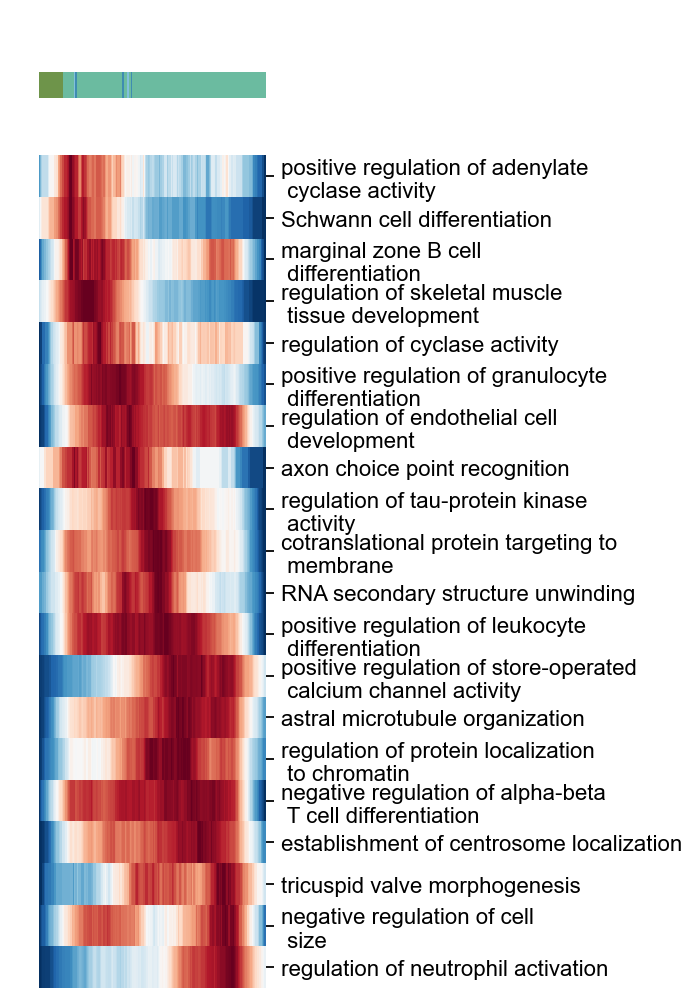

In [228]:
import matplotlib.pyplot as plt
visual_cluster=['20','15']
adata_test=adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster)]
adata_test=adata_test[adata_test.obs['celltype'].isin(['CLP','proB', 'preproB', 'preB', 'NaiveB'])]

g=ov.utils.plot_heatmap(adata_test,
                        var_names=od_genes.index.tolist(),
                  sortby='palantir_pseudotime',col_color='celltype',yticklabels=True,
                 n_convolve=50,figsize=(1,6),show=False)

g.fig.set_size_inches(2, 8)
g.ax_heatmap.set_yticklabels([plot_text_set(i.get_text().split('(')[0],4) for i in g.ax_heatmap.get_yticklabels()],fontsize=10)

plt.savefig(f'figures/geneset/heatmap-lineage-B-ct-28.png',dpi=300,bbox_inches='tight')

In [162]:
ov.utils.plot_text_set(gene.split('(')[0])

'marginal zone \nB cell differentiation \n '

In [225]:
scores = adata_aucs_all.var["change_scores_lineage"]
scores.sort_values(ascending=False)

Regulon
CRD-mediated mRNA stabilization (GO:0070934)                                            0.003390
peptidyl-cysteine S-nitrosylation (GO:0018119)                                          0.002931
positive regulation of maintenance of sister chromatid cohesion (GO:0034093)            0.002533
regulation of maintenance of mitotic sister chromatid cohesion (GO:0034182)             0.002533
positive regulation of maintenance of mitotic sister chromatid cohesion (GO:0034184)    0.002533
                                                                                          ...   
lipid homeostasis (GO:0055088)                                                          0.000000
lipid droplet organization (GO:0034389)                                                 0.000000
lipid catabolic process (GO:0016042)                                                    0.000000
positive regulation of smooth muscle cell differentiation (GO:0051152)                  0.000000
phototransduction, vis

In [226]:
od_genes=scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:20]
od_genes

Regulon
positive regulation of store-operated calcium channel activity (GO:1901341)    0.001725
regulation of neutrophil activation (GO:1902563)                               0.001143
tricuspid valve morphogenesis (GO:0003186)                                     0.001104
astral microtubule organization (GO:0030953)                                   0.001103
regulation of cyclase activity (GO:0031279)                                    0.001085
cotranslational protein targeting to membrane (GO:0006613)                     0.001067
axon choice point recognition (GO:0016198)                                     0.001033
marginal zone B cell differentiation (GO:0002315)                              0.000984
positive regulation of granulocyte differentiation (GO:0030854)                0.000956
establishment of centrosome localization (GO:0051660)                          0.000889
Schwann cell differentiation (GO:0014037)                                      0.000869
regulation of skeletal m

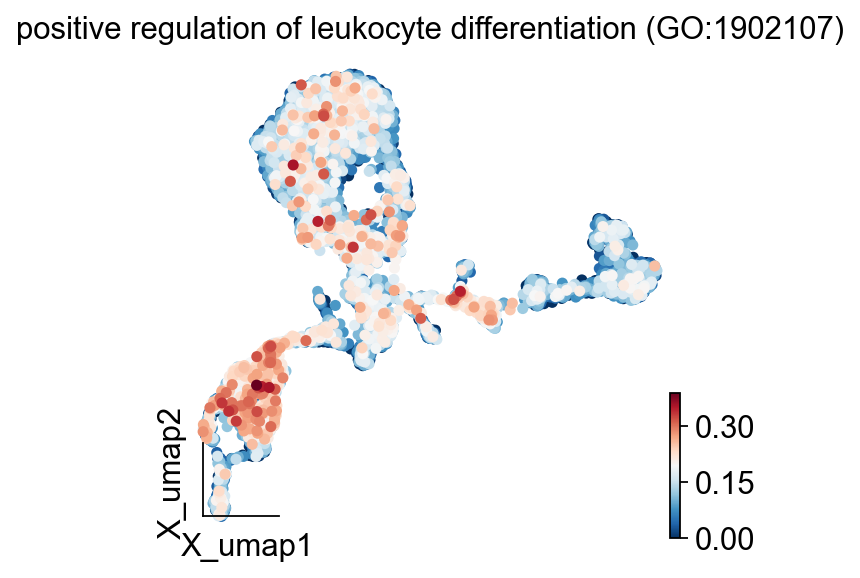

In [122]:
ov.pl.embedding(adata_aucs_all,
                  basis='X_umap',
                  color='positive regulation of leukocyte differentiation (GO:1902107)',
                  frameon='small',size=100)

[Text(1, 0.5, 'marginal zone B cell differentiation (GO:0002315)'),
 Text(1, 1.5, 'positive regulation of adenylate cyclase activity (GO:0045762)'),
 Text(1, 2.5, 'Schwann cell differentiation (GO:0014037)'),
 Text(1, 3.5, 'regulation of skeletal muscle tissue development (GO:0048641)'),
 Text(1, 4.5, 'negative regulation of cell size (GO:0045792)'),
 Text(1, 5.5, 'regulation of endothelial cell development (GO:1901550)'),
 Text(1, 6.5, 'regulation of cyclase activity (GO:0031279)'),
 Text(1, 7.5, 'positive regulation of granulocyte differentiation (GO:0030854)'),
 Text(1, 8.5, 'regulation of tau-protein kinase activity (GO:1902947)'),
 Text(1, 9.5, 'tricuspid valve morphogenesis (GO:0003186)'),
 Text(1, 10.5, 'axon choice point recognition (GO:0016198)'),
 Text(1, 11.5, 'cotranslational protein targeting to membrane (GO:0006613)'),
 Text(1, 12.5, 'RNA secondary structure unwinding (GO:0010501)'),
 Text(1, 13.5, 'regulation of neutrophil activation (GO:1902563)'),
 Text(1, 14.5, 'regul

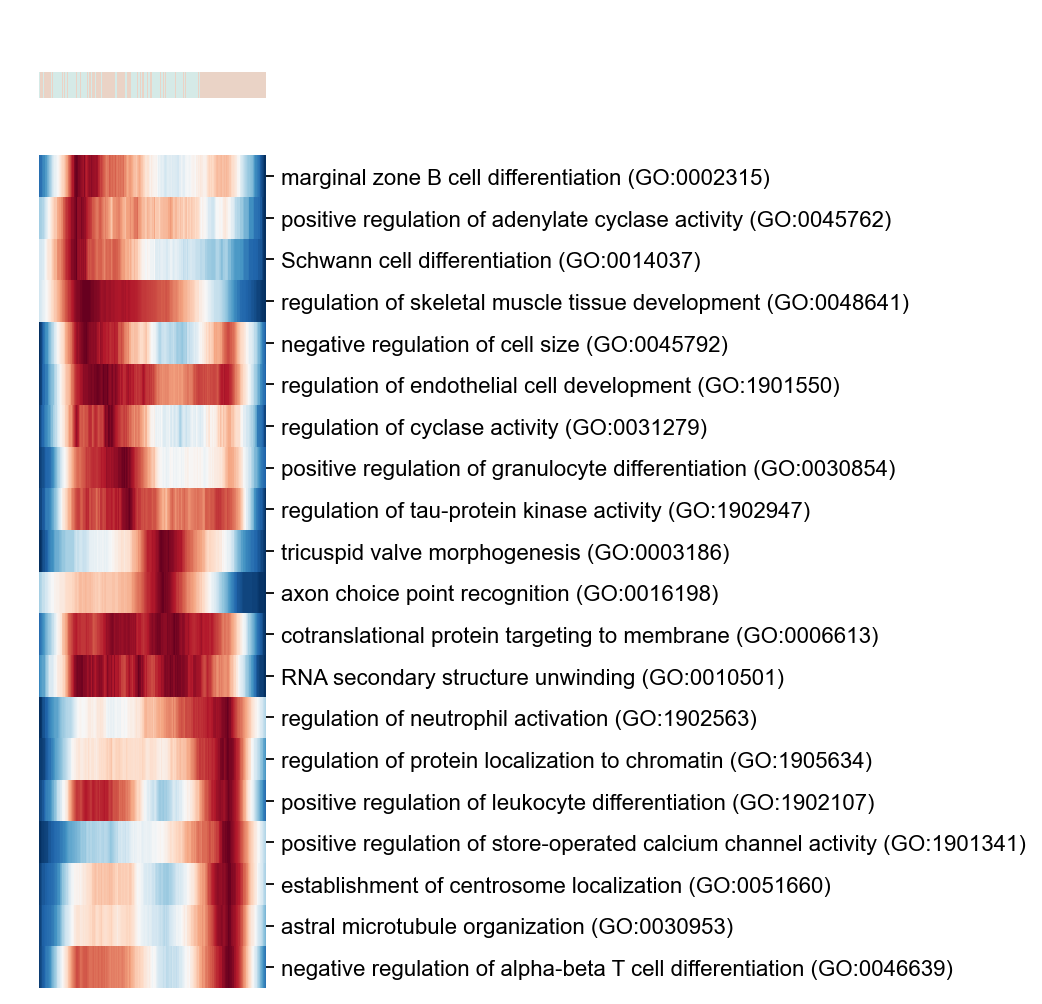

In [126]:
import matplotlib.pyplot as plt
visual_cluster=['20','15']
g=ov.utils.plot_heatmap(adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster)],
                        var_names=od_genes.index.tolist(),
                  sortby='palantir_pseudotime',col_color='leiden',yticklabels=True,
                 n_convolve=100,figsize=(1,6),show=False)

g.fig.set_size_inches(2, 8)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=10)

In [134]:
gw_obj=ov.utils.geneset_wordcloud(adata=adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster),scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:100].index.tolist()],
                                  cluster_key='celltype',pseudotime='palantir_pseudotime',figsize=(3,8))
#gw_obj.adata.uns['celltype_colors']=['#4daf4a', '#f781bf', '#a6d854']
gw_obj.get()

proB 300 152
pDC 300 64
CLP 300 80
Mono 300 288
preB 300 112
preproB 300 104


{'proB': <wordcloud.wordcloud.WordCloud at 0x7faa6e814af0>,
 'pDC': <wordcloud.wordcloud.WordCloud at 0x7faa6eed7730>,
 'CLP': <wordcloud.wordcloud.WordCloud at 0x7faa6e815300>,
 'Mono': <wordcloud.wordcloud.WordCloud at 0x7faa6e823fa0>,
 'preB': <wordcloud.wordcloud.WordCloud at 0x7faa6e822f20>,
 'preproB': <wordcloud.wordcloud.WordCloud at 0x7faa6e823a90>}

Text(0.18, 0.95, 'CellFateGenie')

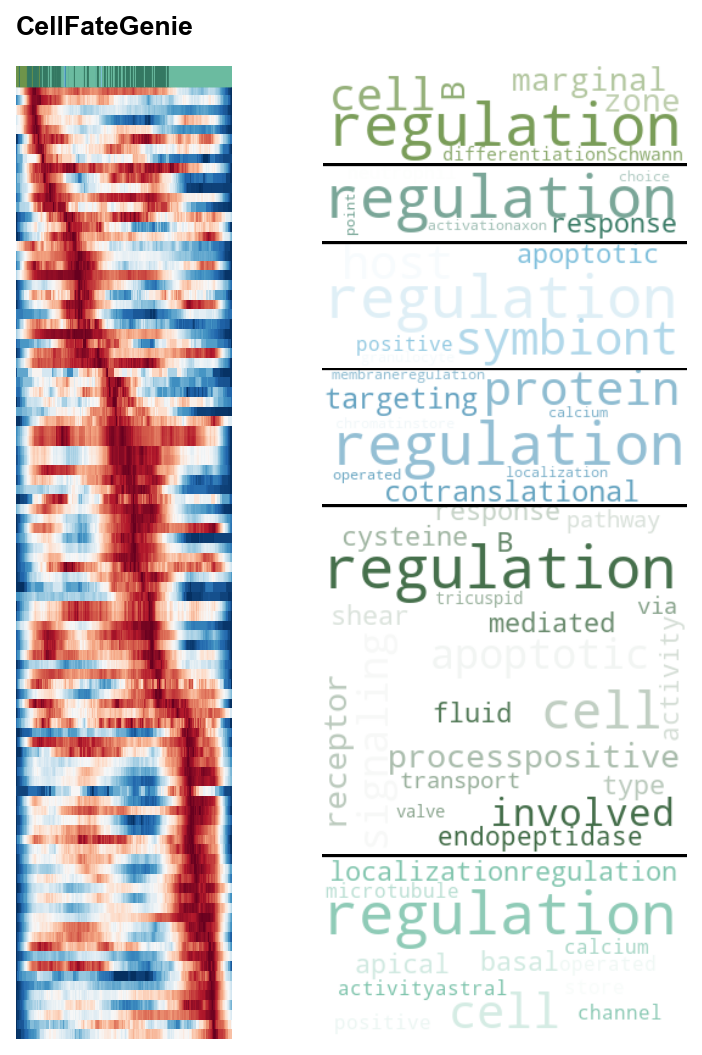

In [137]:
g=gw_obj.plot_heatmap(figwidth=6,cmap='RdBu_r',n_convolve=50,)
plt.suptitle('CellFateGenie',x=0.18,y=0.95,
               horizontalalignment='left',fontsize=12,fontweight='bold')

### Ery

In [187]:
cfg_obj3.lineage_score(cluster_key='leiden',lineage=['12','16'],
                      expression_key=None)
#palantir,mellon

Calculating lineage score
The lineage score stored in adata.var['change_scores_lineage']


In [188]:
scores = adata_aucs_all.var["change_scores_lineage"]
scores.sort_values(ascending=False)

Regulon
CRD-mediated mRNA stabilization (GO:0070934)                                            0.002161
peptidyl-cysteine S-nitrosylation (GO:0018119)                                          0.001931
positive regulation of maintenance of sister chromatid cohesion (GO:0034093)            0.001350
positive regulation of maintenance of mitotic sister chromatid cohesion (GO:0034184)    0.001350
regulation of maintenance of mitotic sister chromatid cohesion (GO:0034182)             0.001350
                                                                                          ...   
growth hormone receptor signaling pathway (GO:0060396)                                  0.000000
granulocyte migration (GO:0097530)                                                      0.000000
granulocyte chemotaxis (GO:0071621)                                                     0.000000
positive regulation of myeloid leukocyte differentiation (GO:0002763)                   0.000000
phototransduction, vis

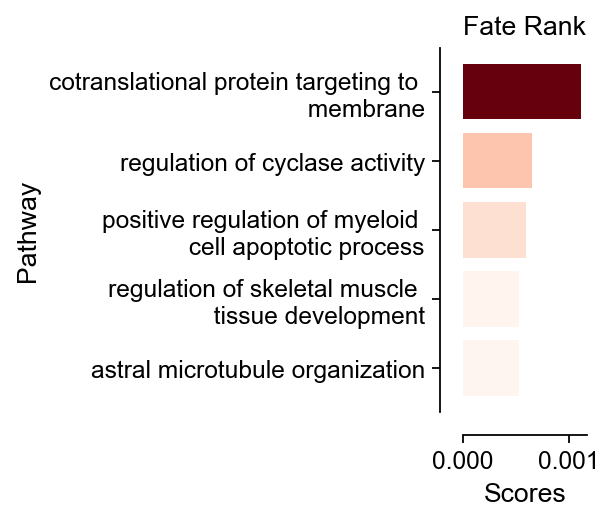

In [213]:
# 创建横向柱状图
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(1, 3))

od_genes=scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:5]

norm = plt.Normalize(min(od_genes.values), max(od_genes.values))
colors = cm.Reds(norm(od_genes.values))

plt.barh(od_genes.index, od_genes.values, color=colors)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('')
ax.set_ylabel('$R^2$', fontsize=13)
ax.set_title('', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
ax.set_yticklabels([plot_text_set(i.get_text().split('(')[0],4) for i in ax.get_yticklabels()], fontsize=11)

plt.xlabel('Scores',fontsize=12)
plt.ylabel('Pathway',fontsize=12)
plt.title('Fate Rank',fontsize=12)
plt.gca().invert_yaxis()  # 反转y轴使得最高分数在顶部



In [189]:
od_genes=scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:20]
od_genes

Regulon
cotranslational protein targeting to membrane (GO:0006613)                     0.001121
regulation of cyclase activity (GO:0031279)                                    0.000657
positive regulation of myeloid cell apoptotic process (GO:0033034)             0.000603
regulation of skeletal muscle tissue development (GO:0048641)                  0.000535
astral microtubule organization (GO:0030953)                                   0.000528
RNA secondary structure unwinding (GO:0010501)                                 0.000522
positive regulation of leukocyte apoptotic process (GO:2000108)                0.000482
negative regulation of cell size (GO:0045792)                                  0.000472
peptide biosynthetic process (GO:0043043)                                      0.000466
Schwann cell differentiation (GO:0014037)                                      0.000465
negative regulation of transporter activity (GO:0032410)                       0.000438
regulation of protein lo

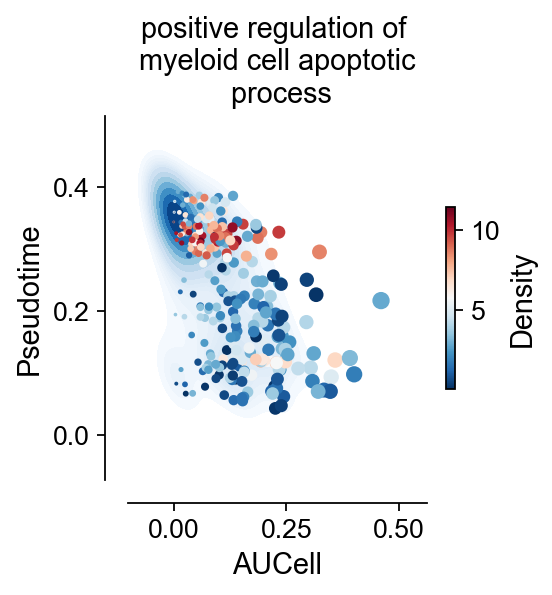

In [219]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(3,3))

path='positive regulation of myeloid cell apoptotic process (GO:0033034)'
visual_cluster=['12','16']

x=adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster),path].to_df().values.reshape(-1)
y=adata_aucs_all.obs.loc[adata_aucs_all.obs['leiden'].isin(visual_cluster),'palantir_pseudotime'].values.reshape(-1)
z=adata_aucs_all.obs.loc[adata_aucs_all.obs['leiden'].isin(visual_cluster),'mellon_log_density_lowd'].values.reshape(-1)

sns.kdeplot(
        x=x, y=y,
        fill=True,
        cmap='Blues',
        #clip=(-5, 5), cut=10,
        thresh=0.1, levels=15,
        ax=ax,#cbar=True,
    )
scatter=ax.scatter(x,y,
           c=z, s=x*100,
           cmap='RdBu_r',
          )

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

plt.xlabel('AUCell',fontsize=13)
plt.ylabel('Pseudotime',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(plot_text_set(path.split('(')[0],text_knock=3, text_maxsize=20),fontsize=13)
cbar = plt.colorbar(scatter, ax=ax,shrink=0.5)
cbar.set_label('Density', fontsize=13)
cbar.ax.tick_params(labelsize=12)

plt.savefig(f'figures/geneset/density-lineage-Ery-{path.split("(")[1]}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/density-lineage-Ery-{path.split("(")[1]}.pdf',dpi=300,bbox_inches='tight')


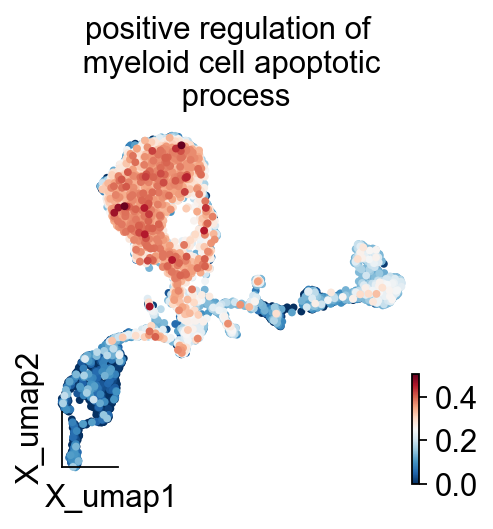

In [220]:
#path='cotranslational protein targeting to membrane (GO:0006613)'
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(adata_aucs_all,
                  basis='X_umap',
                  color=path,
                  title=plot_text_set(path.split('(')[0],3),
                ax=ax,show=False,
                  frameon='small',size=50)
plt.savefig(f'figures/geneset/umap-lineage-Ery-{path.split("(")[1]}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/geneset/umap-lineage-Ery-{path.split("(")[1]}.pdf',dpi=300,bbox_inches='tight')


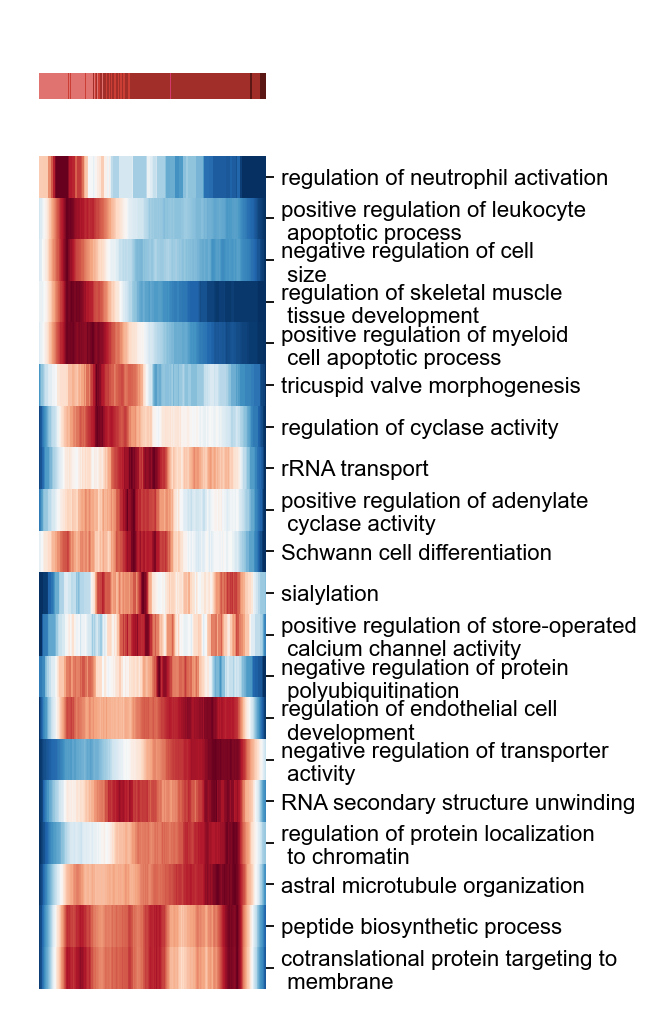

In [203]:
import matplotlib.pyplot as plt
visual_cluster=['12','16']
adata_test=adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster)]
adata_test=adata_test[adata_test.obs['celltype'].isin(['MEP','Mega','EryPre1','EryPre2','MylEry','Ery'])]

g=ov.utils.plot_heatmap(adata_test,
                        var_names=od_genes.index.tolist(),
                  sortby='palantir_pseudotime',col_color='celltype',yticklabels=True,
                 n_convolve=100,figsize=(1,6),show=False)

g.fig.set_size_inches(2, 8)
g.ax_heatmap.set_yticklabels([plot_text_set(i.get_text().split('(')[0],4) for i in g.ax_heatmap.get_yticklabels()],fontsize=10)

plt.savefig(f'figures/geneset/heatmap-lineage-Ery-ct-28.png',dpi=300,bbox_inches='tight')

In [195]:
adata_test=adata_aucs_all[adata_aucs_all.obs['leiden'].isin(visual_cluster)]
adata_test=adata_test[adata_test.obs['celltype'].isin(['MEP','Mega','EryPre1','EryPre2','MylEry','Ery'])]

gw_obj=ov.utils.geneset_wordcloud(adata=adata_test[:,
                                  scores.loc[cfg_obj3.filter_coef.index].sort_values(ascending=False)[:100].index.tolist()],
                                  cluster_key='celltype',pseudotime='palantir_pseudotime',figsize=(3,8))
#gw_obj.adata.uns['celltype_colors']=['#4daf4a', '#f781bf', '#a6d854']
gw_obj.get()

EryPre1 300 24
MEP 300 160
EryPre2 300 96
MylEry 300 248
Mega 300 272


{'EryPre1': <wordcloud.wordcloud.WordCloud at 0x7faa33593af0>,
 'MEP': <wordcloud.wordcloud.WordCloud at 0x7faa33baba90>,
 'EryPre2': <wordcloud.wordcloud.WordCloud at 0x7faa33593e80>,
 'MylEry': <wordcloud.wordcloud.WordCloud at 0x7faa33412c50>,
 'Mega': <wordcloud.wordcloud.WordCloud at 0x7faa33413190>}

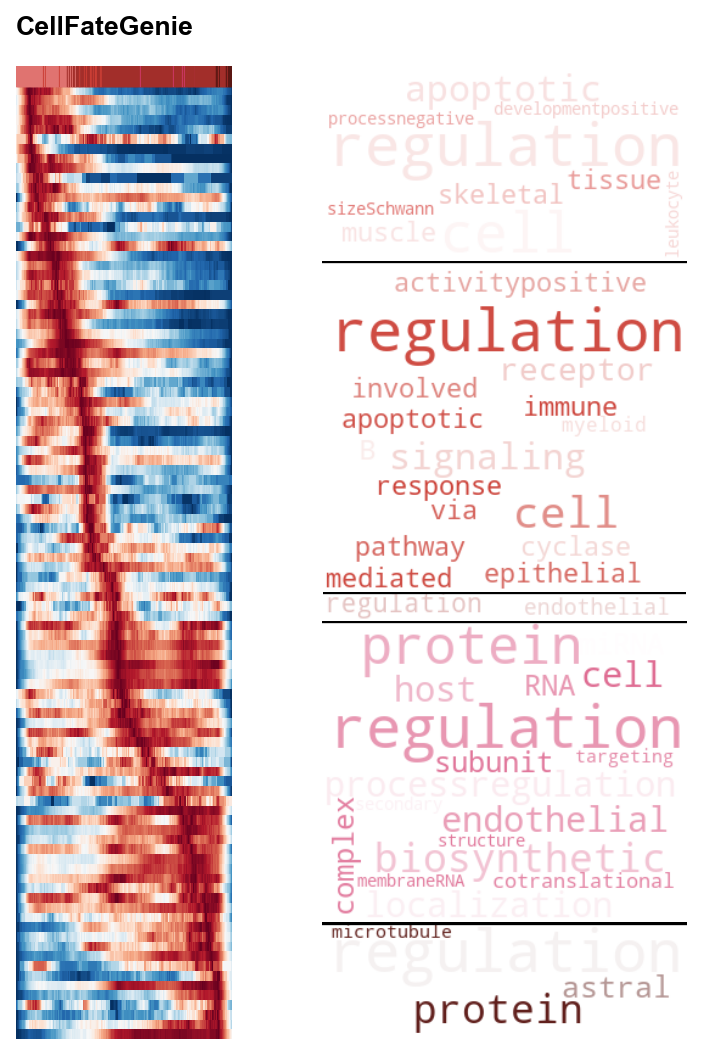

In [204]:
g=gw_obj.plot_heatmap(figwidth=6,cmap='RdBu_r',n_convolve=50,)
plt.suptitle('CellFateGenie',x=0.18,y=0.95,
               horizontalalignment='left',fontsize=12,fontweight='bold')

plt.savefig(f'figures/geneset/word-heatmap-lineage-Ery-ct-28.png',dpi=300,bbox_inches='tight')